In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
df = pd.read_excel("DOWJONESdata.xlsx", engine='openpyxl')

In [3]:
df = df.dropna()
df.head()

,Strike,Ticker,Bid,Ask,Ultimo,IVM,Volm
1,415,DJX 2/21/25 C415,30.00,39.549999,15.700000,19.309093,0.0
2,420,DJX 2/21/25 C420,25.00,34.700001,19.219999,17.420195,0.0
3,425,DJX 2/21/25 C425,20.00,29.950001,23.950001,15.700809,2.0
4,430,DJX 2/21/25 C430,20.10,20.500000,15.800000,14.687160,0.0
5,435,DJX 2/21/25 C435,15.65,16.049999,15.450000,13.859950,1.0


In [4]:
def clean_data(df):
    df = df.rename(columns={
        'Strike': 'Strike', 'IVM': 'ImpliedVolatility',
    })
    df['ImpliedVolatility'] = df['ImpliedVolatility'].astype(float) / 100  # Convert to decimal
    return df
    
def parse_ticker_to_date(ticker):
    parts = ticker.split()
    if len(parts) < 3:
        return None

    date_part = parts[1]
    
    try:
        expiry_date = datetime.strptime(date_part, "%m/%d/%y")  # Convert to datetime
        return expiry_date
    except ValueError:
        return None 
        
df["ExpirationDate"] = df["Ticker"].apply(parse_ticker_to_date)
df = clean_data(df)
unique_maturities = sorted(df['ExpirationDate'].unique())
forward_prices = [449.42, 450.32, 451.47, 454.07, 457.71]

maturity_to_forward = {maturity: forward_prices[i] for i, maturity in enumerate(unique_maturities)}

df['IFwd'] = df['ExpirationDate'].map(maturity_to_forward)
df

,Strike,Ticker,Bid,Ask,Ultimo,ImpliedVolatility,Volm,ExpirationDate,IFwd
1,415,DJX 2/21/25 C415,30.000000,39.549999,15.700000,0.193091,0.0,2025-02-21,449.42
2,420,DJX 2/21/25 C420,25.000000,34.700001,19.219999,0.174202,0.0,2025-02-21,449.42
3,425,DJX 2/21/25 C425,20.000000,29.950001,23.950001,0.157008,2.0,2025-02-21,449.42
4,430,DJX 2/21/25 C430,20.100000,20.500000,15.800000,0.146872,0.0,2025-02-21,449.42
5,435,DJX 2/21/25 C435,15.650000,16.049999,15.450000,0.138600,1.0,2025-02-21,449.42
...,...,...,...,...,...,...,...,...,...
75,445,DJX 9/19/25 C445,25.450001,26.400000,26.660000,0.134210,0.0,2025-09-19,457.71
76,450,DJX 9/19/25 C450,22.150000,23.100000,0.000000,0.129899,0.0,2025-09-19,457.71
77,460,DJX 9/19/25 C460,16.200001,17.100000,14.850000,0.122589,0.0,2025-09-19,457.71
78,470,DJX 9/19/25 C470,11.250000,12.150000,8.950000,0.116267,0.0,2025-09-19,457.71


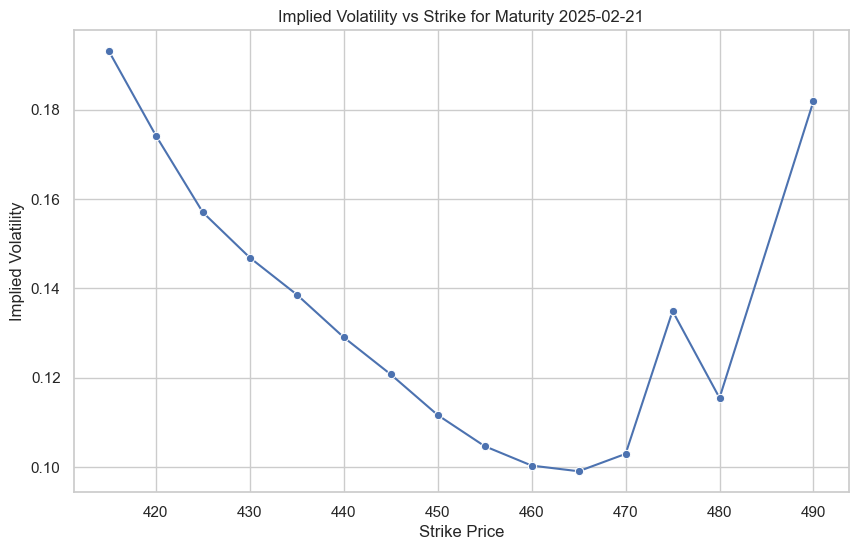

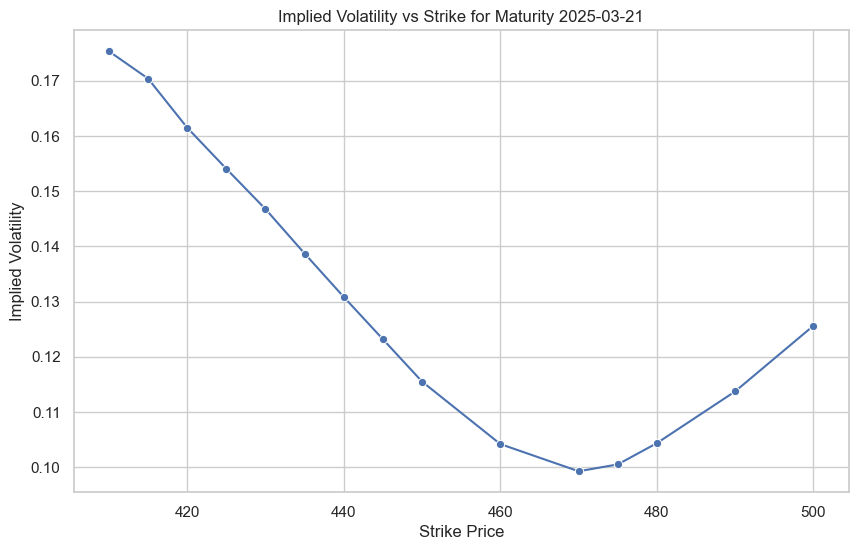

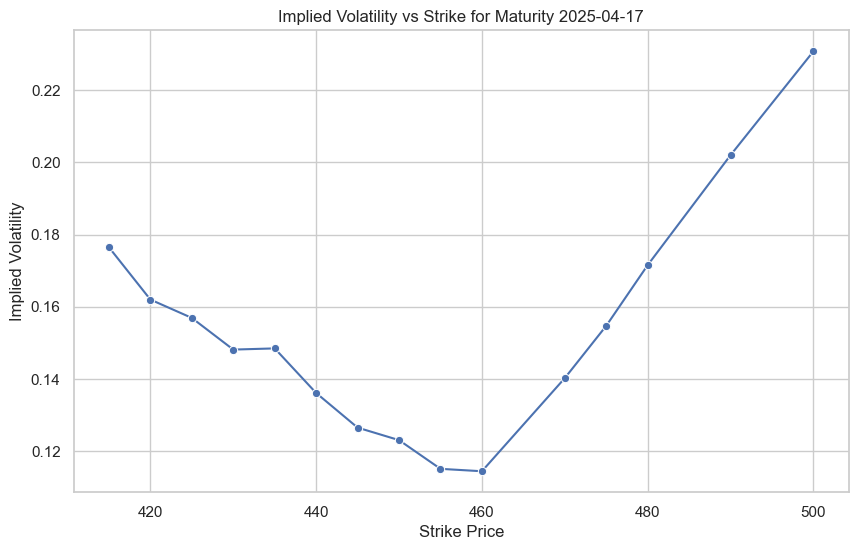

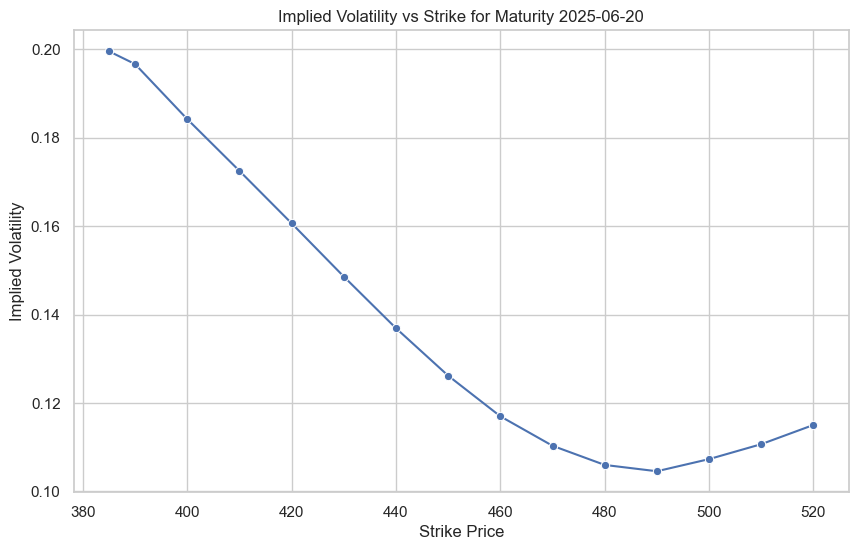

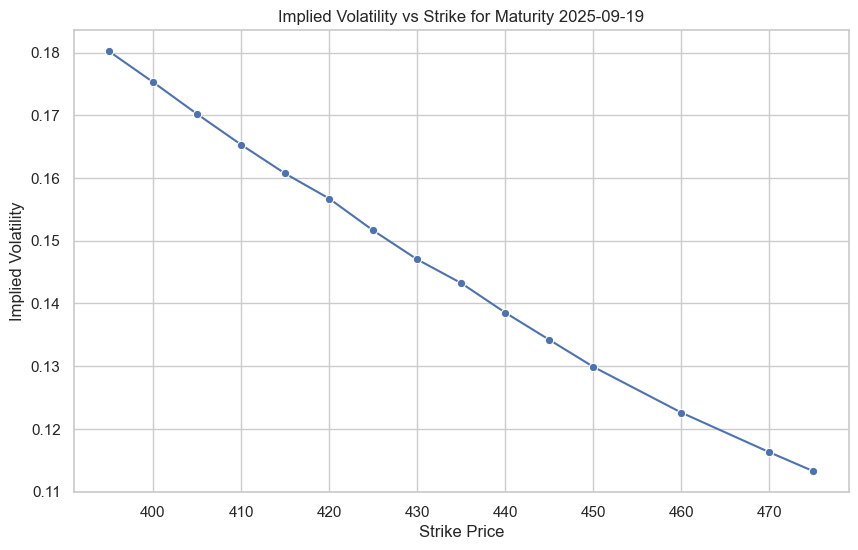

In [13]:
df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'])

unique_maturities = df['ExpirationDate'].unique()

sns.set(style="whitegrid")

for maturity in unique_maturities:
    subset = df[df['ExpirationDate'] == maturity]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subset, x='Strike', y='ImpliedVolatility', marker='o')

    plt.title(f'Implied Volatility vs Strike for Maturity {maturity.date()}')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.grid(True)
    plt.savefig(f'{maturity.date()}.png')
    plt.show()

In [6]:
def sabr_vol(F, K, alpha, beta, rho, nu):
    if F == K:
        # ATM case (limit as K -> F)
        term1 = alpha / (F ** (1 - beta))
        term2 = 1 + (((1 - beta) ** 2) / 24) * (alpha ** 2 / (F ** (2 - 2 * beta))) + \
                (rho * beta * nu * alpha) / (4 * (F ** (1 - beta))) + \
                ((2 - 3 * rho ** 2) / 24) * nu ** 2
        return term1 * term2
    else:
        logFK = np.log(F / K)
        FK_avg = (F * K) ** ((1 - beta) / 2)
        z = (nu / alpha) * FK_avg * logFK
        if abs(z) < 1e-8:
            return sabr_vol(F, K, alpha, beta, rho, nu)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
        term1 = alpha / ((F * K) ** ((1 - beta) / 2))
        return term1 * (z / x_z)

In [7]:
def global_calibration_error(params, market_df, collection_date, S0, r):
    alpha, beta, rho, nu = params
    error = 0.0
    # Group market data by ExpirationDate (each maturity)
    for maturity, group in market_df.groupby('ExpirationDate'):
        T = (pd.to_datetime(maturity) - collection_date).days / 365.0
        # If an IFwd value exists (and is non-NaN) in this group, use it.
        if group['IFwd'].notna().any():
            F = group['IFwd'].dropna().iloc[0]
        else:
            F = S0 * np.exp(r * T)
        for idx, row in group.iterrows():
            K = row['Strike']
            vol_market = row['ImpliedVolatility']
            vol_model = sabr_vol(F, K, alpha, beta, rho, nu)
            error += (vol_market - vol_model) ** 2
    return error

In [8]:
def simulated_annealing(obj_func, init_params, market_df, collection_date, S0, r,
                        T0=1.0, alpha_temp=0.95, n_iter=1000):
    current_params = np.array(init_params)
    current_error = obj_func(current_params, market_df, collection_date, S0, r)
    best_params = current_params.copy()
    best_error = current_error
    T = T0
    for i in range(n_iter):
        new_params = current_params + np.random.normal(scale=0.01, size=current_params.shape)
        # Enforce bounds: beta in [0,1], rho in (-1,1), alpha, nu > 0
        new_params[1] = np.clip(new_params[1], 0.0, 1.0)
        new_params[2] = np.clip(new_params[2], -0.999, 0.999)
        new_params[0] = max(new_params[0], 1e-5)
        new_params[3] = max(new_params[3], 1e-5)
        
        new_error = obj_func(new_params, market_df, collection_date, S0, r)
        delta = new_error - current_error
        
        if delta < 0 or np.exp(-delta / T) > np.random.rand():
            current_params = new_params
            current_error = new_error
            if new_error < best_error:
                best_params = new_params
                best_error = new_error
        T *= alpha_temp
    return best_params, best_error

In [9]:
r = 0.0435
S0 = 448.5 
collection_date = pd.to_datetime("2025-01-28")
init_params = [0.2, 0.2, -0.5, 0.2]

best_params, error = simulated_annealing(global_calibration_error, init_params,
                                           df, collection_date, S0, r,
                                           T0=1.0, alpha_temp=0.95, n_iter=2000)
print("Global Calibrated Parameters [alpha, beta, rho, nu]:", best_params)
print("Global Calibration Error:", error)

Global Calibrated Parameters [alpha, beta, rho, nu]: [ 0.45599361  0.79339474 -0.32113977  1.39408902]
Global Calibration Error: 0.03399154347690187


In [10]:
def simulate_sabr(S0, sigma0, beta, rho, nu, T=1.0, n_steps=252, n_paths=10000):

    dt = T / n_steps
    S_paths = np.zeros((n_paths, n_steps+1))
    sigma_paths = np.zeros((n_paths, n_steps+1))
    S_paths[:, 0] = S0
    sigma_paths[:, 0] = sigma0
    
    for t in range(1, n_steps+1):
        Z1 = np.random.normal(0, 1, n_paths)
        Z2 = np.random.normal(0, 1, n_paths)
        dW = np.sqrt(dt) * Z1
        dZ = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)
        
        base = np.maximum(S_paths[:, t-1], 1e-5)
        S_paths[:, t] = S_paths[:, t-1] + sigma_paths[:, t-1] * (base ** beta) * dW
        sigma_paths[:, t] = sigma_paths[:, t-1] + nu * sigma_paths[:, t-1] * dZ
    return S_paths, sigma_paths

def price_asian_option(S_paths, strike):
    S_avg = S_paths.mean(axis=1)
    payoffs = np.maximum(S_avg - strike, 0)
    return np.mean(payoffs)

T_maturity = 1
F = S0 * np.exp(r * T_maturity)
print(f"Forward Price F at T = {T_maturity} using r = {r} is: {F:.2f}")

sigma0, beta_cal, rho_cal, nu_cal = best_params

S0_sim = F

n_steps = 252
n_paths = 10000
strike = S0_sim

S_paths, _ = simulate_sabr(S0_sim, sigma0, beta_cal, rho_cal, nu_cal, T=T_maturity, n_steps=n_steps, n_paths=n_paths)
asian_price = price_asian_option(S_paths, strike)
print("Asian Option Price:", asian_price)

Forward Price F at T = 1 using r = 0.0435 is: 468.44
Asian Option Price: 14.52894870574005
